<h1> Data Preprocessing </h1>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
import random
# --------------------

In [2]:
image_folder = "images"   # <- change
csv_file = "face_keypoints.csv"       # <- change
img_size = (128, 128)
batch_size = 32
seed = 42

# --------------------
# Helpers: load & clean dataframe
# --------------------
def load_and_clean_df(csv_file, image_folder, drop_missing=True):
    df = pd.read_csv(csv_file)
    # expected columns: image_name, point_1_x, point_1_y, ..., point_5_x, point_5_y
    required_cols = ['image_name'] + [f'point_{i}_{ax}' for i in range(1,6) for ax in ('x','y')]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"CSV missing columns: {missing}")

    # Drop rows with missing keypoints (we used -1.0 as fallback earlier)
    if drop_missing:
        coord_cols = required_cols[1:]
        # drop any row where any coord < 0 (missing)
        df = df[~(df[coord_cols] < 0).any(axis=1)].copy()

    # Filter out rows where image file doesn't exist
    df['image_path'] = df['image_name'].apply(lambda n: os.path.join(image_folder, n))
    df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)
    return df


In [ ]:
class KeypointSequence(Sequence):
    def __init__(self, df, batch_size=32, img_size=(128,128), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        # for batch 1, idx=0  hence, self.indices[0:32]
        # for batch 2, idx=1  hence, self.indices[32:64]
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_idx]

        images, keypoints = [], []

        for _, row in batch_df.iterrows():
            # Load image
            img_path = row['image_path'] if 'image_path' in row else os.path.join(image_folder, row['image_name'])
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Failed to load image: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img.astype("float32") / 255.0

            # Extract keypoints
            pts = np.array([
                [row['point_1_x'], row['point_1_y']],
                [row['point_2_x'], row['point_2_y']],
                [row['point_3_x'], row['point_3_y']],
                [row['point_4_x'], row['point_4_y']],
                [row['point_5_x'], row['point_5_y']]
            ], dtype="float32")

            images.append(img)
            keypoints.append(pts.flatten())

        return np.array(images), np.array(keypoints)

In [10]:

# --------------------
# Prepare split & generators
# --------------------
def create_generators(csv_file, image_folder, img_size=(128,128),
                      batch_size=32, test_ratio=0.1, val_ratio=0.1, drop_missing=True):
    df = load_and_clean_df(csv_file, image_folder, drop_missing=drop_missing)
    print(f"Total valid samples after cleaning: {len(df)}")

        # Save cleaned dataset to new CSV
    clean_csv_file = "cleaned_MNET_NoAug.csv"
    df.to_csv(clean_csv_file, index=False)
    print(f"✅ Cleaned dataset saved to {clean_csv_file}")


    # first split out test
    df_trainval, df_test = train_test_split(df, test_size=test_ratio, random_state=seed)
    # split train and val from trainval
    val_relative = val_ratio / (1.0 - test_ratio)
    df_train, df_val = train_test_split(df_trainval, test_size=val_relative, random_state=seed)

    print("Splits -> train:", len(df_train), "val:", len(df_val), "test:", len(df_test))

    train_seq = KeypointSequence(df_train, batch_size=batch_size, img_size=img_size, shuffle=True)
    val_seq = KeypointSequence(df_val, batch_size=batch_size, img_size=img_size, shuffle=False)
    test_seq = KeypointSequence(df_test, batch_size=batch_size, img_size=img_size, shuffle=False)

    return train_seq, val_seq, test_seq

In [ ]:

if __name__ == "__main__": # runs only when this file is executed directly, not when imported
    train_seq, val_seq, test_seq = create_generators(
        csv_file=csv_file,
        image_folder=image_folder,
        img_size=img_size,
        batch_size=batch_size,
        test_ratio=0.1,
        val_ratio=0.1,
        # augment=True,
        drop_missing=True
    )

Total valid samples after cleaning: 69993
✅ Cleaned dataset saved to cleaned_MNET_NoAug.csv
Splits -> train: 55993 val: 7000 test: 7000


<h1> Model Building </h1>

In [13]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.losses import Huber

In [15]:
img_size = (128, 128, 3)  # Input size (same as your images)
num_keypoints = 5 * 2     # 5 points, each has (x,y)

# ----------------------
# Build model
# ----------------------
def build_model(input_shape=img_size, num_outputs=num_keypoints, freeze_backbone=True):
    # Load MobileNetV2 backbone
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights="imagenet")
    
    if freeze_backbone:
        for layer in base_model.layers:
            layer.trainable = False

    # Add regression head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_outputs, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=outputs, name="KeypointDetector")
    return model

# ----------------------
# Create and compile model
# ----------------------
model = build_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=Huber(),   # regression task
    metrics=["mae"]
)

# model.summary()


<h1> Model Training </h1>

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [18]:
train_seq, val_seq, test_seq = create_generators(
    csv_file="cleaned_MNET_NoAug.csv",   # use cleaned csv
    image_folder="images",      # update to your folder
    img_size=(128,128),
    batch_size=32,
    test_ratio=0.1,
    val_ratio=0.1, 
    drop_missing=True
)

# ----------------------
# Callbacks
# ----------------------
checkpoint_path = "MNET_NoAug.h5"

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

Total valid samples after cleaning: 69993
✅ Cleaned dataset saved to cleaned_MNET_NoAug.csv
Splits -> train: 55993 val: 7000 test: 7000


In [ ]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training complete! Best model saved at:", checkpoint_path)



d:\All\ASSIGNMENT\assignment\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 0.0243 - mae: 0.1368
Epoch 1: val_loss improved from None to 0.00028, saving model to MNET_NoAug.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 792s 451ms/step - loss: 0.0077 - mae: 0.0735 - val_loss: 2.8218e-04 - val_mae: 0.0167
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 3.0976e-04 - mae: 0.0173
Epoch 2: val_loss improved from 0.00028 to 0.00025, saving model to MNET_NoAug.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 268s 153ms/step - loss: 2.7253e-04 - mae: 0.0161 - val_loss: 2.5402e-04 - val_mae: 0.0152
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 2.4256e-04 - mae: 0.0151
Epoch 3: val_loss improved from 0.00025 to 0.00024, saving model to MNET_NoAug.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 228s 130ms/step - loss: 2.4070e-04 - mae: 0.0150 - val_loss: 2.3672e-04 - val_mae: 0.0144
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 2.2904e-04 - mae: 0.0145
Epoch 4: val_loss improved from 0.00024 to 0.00022, saving model to MNET_NoAug.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 259s 148ms/step - loss: 2.2827e-04 - mae: 0.0145 - val_loss: 2.2123e-04 - val_mae: 0.0141
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 2.2286e-04 - mae: 0.0142
Epoch 5: val_loss improved from 0.00022 to 0.00020, saving model to MNET_NoAug.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 255s 146ms/step - loss: 2.1437e-04 - mae: 0.0140 - val_loss: 2.0144e-04 - val_mae: 0.0135
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 2.0233e-04 - mae: 0.0137
Epoch 6: val_loss improved from 0.00020 to 0.00019, saving model to MNET_NoAug.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 614s 351ms/step - loss: 2.0349e-04 - mae: 0.0137 - val_loss: 1.9161e-04 - val_mae: 0.0133
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 2.0106e-04 - mae: 0.0136
Epoch 7: val_loss did not improve from 0.00019
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 240s 137ms/step - loss: 1.9956e-04 - mae: 0.0136 - val_loss: 1.9186e-04 - val_mae: 0.0132
Epoch 8/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 1.9412e-04 - mae: 0.0136
Epoch 8: val_loss did not improve from 0.00019
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 268s 153ms/step - loss: 1.9681e-04 - mae: 0.0136 - val_loss: 1.9713e-04 - val_mae: 0.0135
Epoch 9/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.9472e-04 - mae: 0.0136
Epoch 9: val_loss improved from 0.00019 to 0.00019, saving model to MNET_NoAug.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 283s 162ms/step - loss: 1.9584e-04 - mae: 0.0136 - val_loss: 1.8867e-04 - val_mae: 0.0132
Epoch 10/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 1.9167e-04 - mae: 0.0135
Epoch 10: val_loss did not improve from 0.00019
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 292s 167ms/step - loss: 1.9367e-04 - mae: 0.0135 - val_loss: 1.8946e-04 - val_mae: 0.0132
Epoch 11/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1.9103e-04 - mae: 0.0135
Epoch 11: val_loss improved from 0.00019 to 0.00018, saving model to MNET_NoAug.h5


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 280s 160ms/step - loss: 1.9317e-04 - mae: 0.0135 - val_loss: 1.8124e-04 - val_mae: 0.0129
Epoch 12/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.9170e-04 - mae: 0.0135
Epoch 12: val_loss did not improve from 0.00018
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 278s 159ms/step - loss: 1.9258e-04 - mae: 0.0135 - val_loss: 1.8539e-04 - val_mae: 0.0131
Epoch 13/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 1.8940e-04 - mae: 0.0134
Epoch 13: val_loss did not improve from 0.00018
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 578s 330ms/step - loss: 1.9313e-04 - mae: 0.0135 - val_loss: 2.0060e-04 - val_mae: 0.0134
Epoch 14/50
1062/1750 ━━━━━━━━━━━━━━━━━━━━ 4:27 389ms/step - loss: 1.9167e-04 - mae: 0.0135

KeyboardInterrupt: 

<h1> Evaluation </h1>

In [20]:
import tensorflow as tf

model = tf.keras.models.load_model("MNET_NoAug.h5", compile=False)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [21]:
test_loss, test_mae = model.evaluate(test_seq, verbose=1)
img_size = 128
test_mae_px = test_mae * img_size

print(f"✅ Test Loss (MSE): {test_loss:.4f}")
print(f"✅ Test MAE (normalized): {test_mae:.4f}")
print(f"🎯 Test MAE in pixels: {test_mae_px:.2f} px")

219/219 ━━━━━━━━━━━━━━━━━━━━ 103s 468ms/step - loss: 3.7719e-04 - mean_absolute_error: 0.0130
✅ Test Loss (MSE): 0.0004
✅ Test MAE (normalized): 0.0130
🎯 Test MAE in pixels: 1.66 px


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


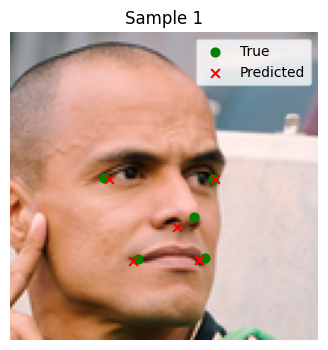

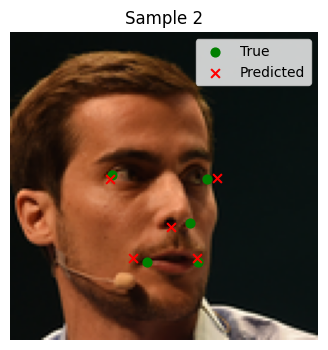

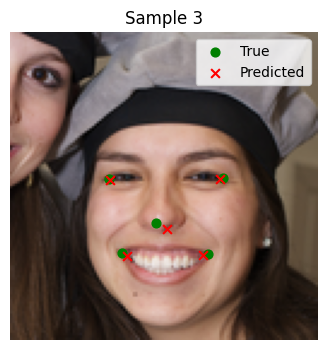

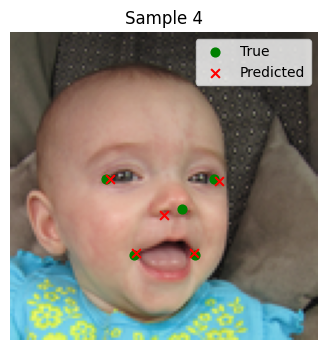

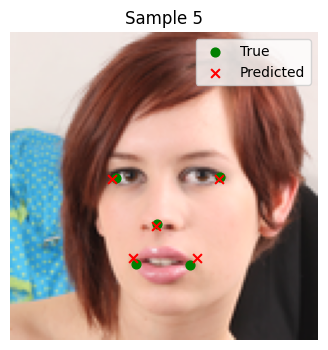

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from test_seq
images, true_kps = test_seq[0]
pred_kps = model.predict(images)

# Plot first 5 samples
for i in range(5):
    img = images[i]
    true_pts = true_kps[i].reshape(-1, 2) * img_size
    pred_pts = pred_kps[i].reshape(-1, 2) * img_size

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.scatter(true_pts[:, 0], true_pts[:, 1], c='green', label='True', s=40)
    plt.scatter(pred_pts[:, 0], pred_pts[:, 1], c='red', label='Predicted', marker='x', s=40)
    plt.title(f"Sample {i+1}")
    plt.legend()
    plt.axis('off')
    plt.show()

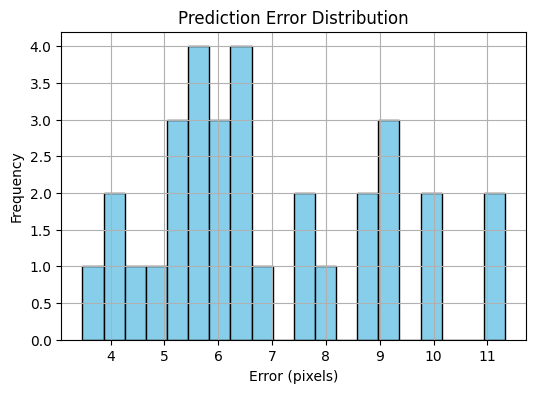

In [25]:
errors = np.linalg.norm(pred_kps - true_kps, axis=1) * img_size  # Euclidean error per sample

plt.figure(figsize=(6, 4))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Error (pixels)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

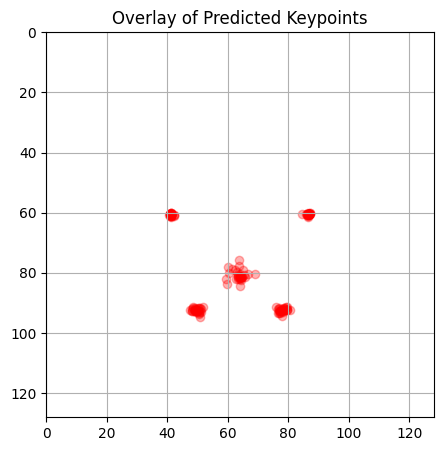

In [26]:
plt.figure(figsize=(5, 5))
for i in range(len(images)):
    pred_pts = pred_kps[i].reshape(-1, 2) * img_size
    plt.scatter(pred_pts[:, 0], pred_pts[:, 1], c='red', alpha=0.3)

plt.title("Overlay of Predicted Keypoints")
plt.xlim(0, img_size)
plt.ylim(img_size, 0)
plt.grid(True)
plt.show()

In [30]:
import numpy as np
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_absolute_error

# Load model
model = tf.keras.models.load_model("MNET_NoAug.h5", compile=False)

# Load test data
_, _, test_seq = create_generators(
    csv_file="cleaned_MNET_Aug.csv",
    image_folder="images",
    img_size=(128,128),
    batch_size=32,
    test_ratio=0.1,
    val_ratio=0.1,
    drop_missing=True
)

# Collect predictions and ground truth
y_true, y_pred = [], []

for batch_x, batch_y in test_seq:
    preds = model.predict(batch_x)
    y_true.append(batch_y)
    y_pred.append(preds)

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Compute MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"📏 Mean Absolute Error (MAE): {mae:.4f}")

# Compute Huber Loss
huber = Huber()
huber_loss = huber(y_true, y_pred).numpy()
print(f"📉 Huber Loss: {huber_loss:.4f}")

Total valid samples after cleaning: 69993
✅ Cleaned dataset saved to cleaned_MNET_NoAug.csv
Splits -> train: 55993 val: 7000 test: 7000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━

In [ ]:
# Save Evaluation Results
def save_evaluation_report(metrics, errors, thresholds, accuracies):
    """Save comprehensive evaluation report"""
    report_path = 'evaluation_report.txt'
    
    with open(report_path, 'w') as f:
        f.write("FACIAL KEYPOINT DETECTION - EVALUATION REPORT\n")
        f.write("=" * 55 + "\n\n")
        
        f.write("OVERALL METRICS:\n")
        f.write("-" * 20 + "\n")
        f.write(f"MSE: {metrics['mse']:.6f}\n")
        f.write(f"MAE (normalized): {metrics['mae_normalized']:.6f}\n")
        f.write(f"MAE (pixels): {metrics['mae_pixels']:.2f}\n")
        f.write(f"Relative Error: {(metrics['mae_pixels']/128*100):.1f}%\n\n")
        
        f.write("PER-KEYPOINT PERFORMANCE:\n")
        f.write("-" * 25 + "\n")
        for name, error in zip(metrics['keypoint_names'], metrics['per_keypoint_mae']):
            f.write(f"{name:12}: {error:.2f} pixels\n")
        
        f.write(f"\nERROR STATISTICS:\n")
        f.write("-" * 20 + "\n")
        f.write(f"Mean Error: {np.mean(errors):.2f} pixels\n")
        f.write(f"Median Error: {np.median(errors):.2f} pixels\n")
        f.write(f"Std Deviation: {np.std(errors):.2f} pixels\n")
        f.write(f"95th Percentile: {np.percentile(errors, 95):.2f} pixels\n\n")
        
        f.write("ACCURACY AT THRESHOLDS:\n")
        f.write("-" * 25 + "\n")
        for thresh, acc in zip(thresholds, accuracies):
            f.write(f"{thresh:2d} pixels: {acc:6.2f}%\n")
    
    print(f"✅ Evaluation report saved to: {report_path}")

save_evaluation_report(metrics, errors, thresholds, accuracies)